In [ ]:
%matplotlib inline

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import astropy as ap
import astropy.table as at
import astropy.units as u
from astropy import constants as const
from astropy.io import ascii
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
import specreduce
from specreduce.calibration_data import AtmosphericTransmission, SUPPORTED_EXTINCTION_MODELS
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

### Margaret Shepherd

The point of this assignment is to:
- to make sure you have a sense of fluxes, magnitudes and distances as a function of redshift
- get familiar with drawing random numbers from a distribution, making cuts on your data
- modeling in the presence of systematic effects and the resulting biases you'll encounter

# Q1. The $k$-correction in the sub-mm and the optical (60 pts)

You know how to calculate the flux synthetically in some band, but what about comparing the flux of the same class of objects at different redshifts. Necessarily, you'll have to compare the rest-frame flux with the observer frame flux further in the red at some redshift $z$ because the Universe is expanding and frequency of photons is shifting. 

To do this, you need the "$k$-correction" which is nicely summarized in Hogg et al. 2002: https://arxiv.org/abs/astro-ph/0210394
(You might start by looking at Eqn. 12, and comparing it to the synthetic integrals for the flux you implemented in Homework 1)

As we discussed in class (or as you might know if you've listened to a talk from Prof. Joaquin Vieira) galaxies have an interesting effect where the flux density $F_\nu$ from about 250$\mu m$ becomes roughly constant over a large range in redshift because you climb the Rayleigh-Jeans tail as you increase redshift, which compensates for the decrease in the flux density because of increasing distance. In the optical, you have no such luck, and indeed, depending on the class of galaxy, the $k$-correction means that galaxies in a fixed observer band might seem even fainter than you might expect from the inverse square law. 

In particular, the $k$-correction goes negative. 

In this problem, you'll implement the k-correction (reuse the code from HW1 and simplify Eqn 12).

I've included an SED of a galaxy ```aless_average_seds.dat``` from Elisabete de Cunha (you can read about it here: http://astronomy.swinburne.edu.au/~ecunha/ecunha/SED_Templates.html) with this homework. The columns are wavelength (in microns), average $F_\nu$ (in mJy), and upper and lower credible regions on the flux density.

Your mission is to make three plots (15 points each for the plot):

- Fig 1. should plot the flux density in mJy of this SED as a function of redshift (see here: https://ned.ipac.caltech.edu/level5/Sept04/Blain/Blain2_5.html) in common bands - assume perfectly rectangular bands with a fixed 3  micron bandwidth around the central wavelengths shown in the above figure. (Hint: this doesn't need you to actually compute the $k$-correction explicitly yet, but you will need to be careful about units and show that you know how to redshift and dim an SED). Evaluate this on a grid of redshift from $z$=1 to $z$=8 (inclusive) with $\Delta z$=0.25 spacing.

- Fig 2. should plot the flux density (in mJy) of the SED as a function of wavelength in microns (see the 2nd animation here: http://www.as.utexas.edu/~cmcasey/animated.html) over the same redshift grid (you can use $\Delta z$=0.50 to make it less cluttered if you like) and overplot the sub-mm bands for BICEP2 (http://svo2.cab.inta-csic.es/theory/fps3/index.php?mode=browse&gname=BICEP&gname2=BICEP2&asttype=) 
  
- Fig 3. should plot the $k$-correction (in magnitudes) itself for LSST giy bands as a function of redshift between $z$=0. and $z=2$ in $\Delta z$=0.01 steps (you can use whatever linestyle you like to join the lines, but make sure you use a different color for each of the observer frames). The Hogg et al. 2002 will need you to specify a rest-frame filter for each of the observer frame filters. Use the same LSST ugrizy filter set and determine which one is at the closest effective wavelength to the observer frame filter's effective wavelength at each redshift. If there is no band that maps well to an observer frame band (i.e. the the rest-frame filter has redshifted out of the observer frame filter) stop computing the $k$-correction for that filter. 

Hint: Astropy has a units module to help convert between different units and an equivalencies option particularly to convert between wavelengths and frequencies (https://docs.astropy.org/en/stable/units/equivalencies.html). You can try to do it by hand, but if you mess it up, you'll get rubbish. It also has a cosmology module to compute luminosity distance as a function of redshift - you can assume a Flat $\Lambda$CDM cosmology. 

### This is not actually all that much code if you break it into a few functions.

In [ ]:
# !wget http://astronomy.swinburne.edu.au/~ecunha/ecunha/SED_Templates_files/aless_average_seds.dat
# https://ui.adsabs.harvard.edu/abs/2015ApJ...806..110D/abstract

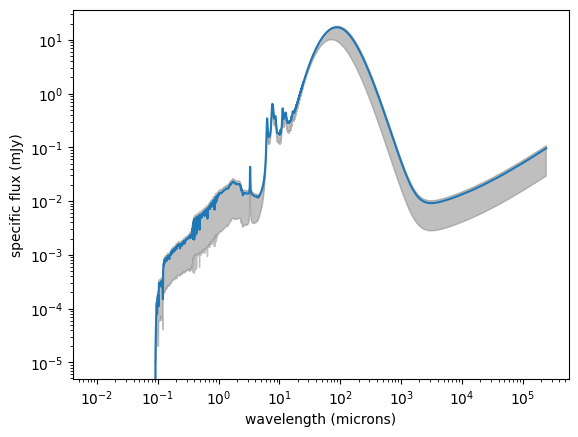

In [2]:
data = at.Table.read('aless_average_seds.dat', format='ascii', names=['wave','fnu', 'fnu_bright', 'fnu_faint'], data_start=1)
# columns are wavelength (in microns), average specific flux (in mJy), 
# and upper and lower credible regions on the flux density
plt.plot(data['wave'], data['fnu'])
plt.fill_between(x = data['wave'], 
                 y1 = data['fnu_faint'], 
                 y2 = data['fnu_bright'], color='gray', alpha=0.5)
plt.xlabel('wavelength (microns)')
plt.ylabel('specific flux (mJy)')
# plt.xlim(10**(0), 10**(4))
plt.xscale('log')
plt.yscale('log')

In [12]:
z = np.linspace(1, 8, (4*7)+1)
# print(z)
H0 = 72*u.km/u.s/u.Mpc
cosmo = FlatLambdaCDM(H0=H0, Tcmb0=2.725 * u.K, Om0=0.3)
D_L = cosmo.luminosity_distance(z)

def shift_sed(z, emit_wave):
    # for an SED containing with emitted wavelengths at redshift z,
    # what wavelength do we observe it at?
    # 1 + z = lam_obs/lam_emit
    obs_wave = emit_wave*(1+z)
    return obs_wave

In [13]:
# filters
fwidth = 3 # microns
f1 = np.linspace(24-(0.5*fwidth), 24+(0.5*fwidth))
f2 = np.linspace(70-(0.5*fwidth), 70+(0.5*fwidth))
f3 = np.linspace(110-(0.5*fwidth), 110+(0.5*fwidth))
f4 = np.linspace(160-(0.5*fwidth), 160+(0.5*fwidth))
f5 = np.linspace(200-(0.5*fwidth), 200+(0.5*fwidth))
f6 = np.linspace(350-(0.5*fwidth), 350+(0.5*fwidth))
f7 = np.linspace(450-(0.5*fwidth), 450+(0.5*fwidth))
f8 = np.linspace(500-(0.5*fwidth), 500+(0.5*fwidth))
f9 = np.linspace(850-(0.5*fwidth), 850+(0.5*fwidth))
f10 = np.linspace(1100-(0.5*fwidth), 1100+(0.5*fwidth))
f11 = np.linspace(1400-(0.5*fwidth), 1400+(0.5*fwidth))
f12 = np.linspace(2100-(0.5*fwidth), 2100+(0.5*fwidth))

In [16]:
def find_synth_flux(band, redshift): 
    if redshift == 0:
        star_wavelength = data['wave'] # microns!
        star_flux = data['fnu'] # mJy!
    else: 
        star_wavelength = shift_sed(redshift, data['wave'])
        star_flux = data['fnu']/(((D_L[np.argwhere(z==redshift)][0][0])**2)*(1+redshift)) # mJy!

    
    band_wavelength = band # microns
    response_func = np.ones(len(band)) # perfectly rectangular filters

    star_band_wave = star_wavelength[np.argwhere((band_wavelength[0] < star_wavelength) & (star_wavelength < band_wavelength[-1]))][:,0]
    star_band_flux = star_flux[np.argwhere((band_wavelength[0] < star_wavelength) & (star_wavelength < band_wavelength[-1]))][:,0]

    if len(star_band_wave) == 0:
        return float('nan')
    else:
        interp_band_response = np.interp(star_band_wave, # star wavelengths within band wavelength parameters
                                      band_wavelength, # response function wavelengths
                                      response_func)  # response function transmission
        # want to return response function transmission at vega wavelengths
        star_band_numerator = sp.integrate.simpson(y=(star_band_wave*star_band_flux*interp_band_response), x=star_band_wave)
        star_band_denominator = sp.integrate.simpson(y=(star_band_wave*interp_band_response), x=star_band_wave)
        star_band_synth_flux = star_band_numerator/star_band_denominator
        return star_band_synth_flux

find_synth_flux(f1, 1)

4.899707299915896e-09

/var/folders/g4/9tv_g07j49d5s37hc0tq7b280000gn/T/ipykernel_13309/1233917630.py:25: RuntimeWarning: invalid value encountered in scalar divide
  star_band_synth_flux = star_band_numerator/star_band_denominator


Text(0.5, 0, 'redshift')

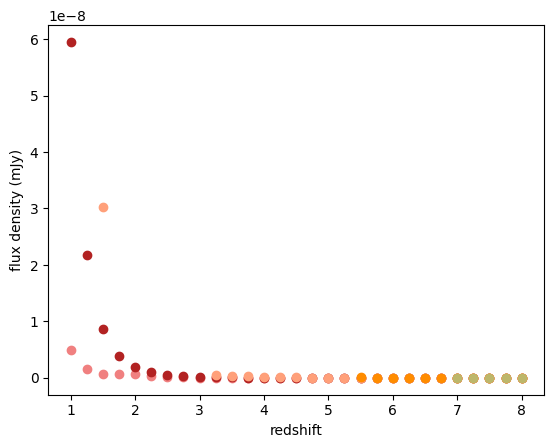

In [17]:
# Figure 1
# plot the flux density in mJy of this SED as a function of redshift in common bands
# y axis: compute synthetic flux density 
# x axis: redshift from 1 to 8 in 0.25 increments
# color code: band 

for redshift in z:
    plt.scatter(redshift, find_synth_flux(f1, redshift), color='lightcoral', label='f1')
    plt.scatter(redshift, find_synth_flux(f2, redshift), color='firebrick', label='f2')
    plt.scatter(redshift, find_synth_flux(f3, redshift), color='lightsalmon', label='f3')
    plt.scatter(redshift, find_synth_flux(f4, redshift), color='darkorange', label='f4')
    plt.scatter(redshift, find_synth_flux(f5, redshift), color='darkkhaki', label='f5')
    plt.scatter(redshift, find_synth_flux(f6, redshift), color='olivedrab', label='f6')
    plt.scatter(redshift, find_synth_flux(f7, redshift), color='darkseagreen', label='f7')
    plt.scatter(redshift, find_synth_flux(f8, redshift), color='darkgreen', label='f8')
    plt.scatter(redshift, find_synth_flux(f9, redshift), color='lightseagreen', label='f9')
    plt.scatter(redshift, find_synth_flux(f10, redshift), color='mediumturquoise', label='f10')
    plt.scatter(redshift, find_synth_flux(f11, redshift), color='deepskyblue', label='f11')
    plt.scatter(redshift, find_synth_flux(f12, redshift), color='royalblue', label='f12')
plt.ylabel('flux density (mJy)')
plt.xlabel('redshift')

(0.00031622776601683794, 10000000)

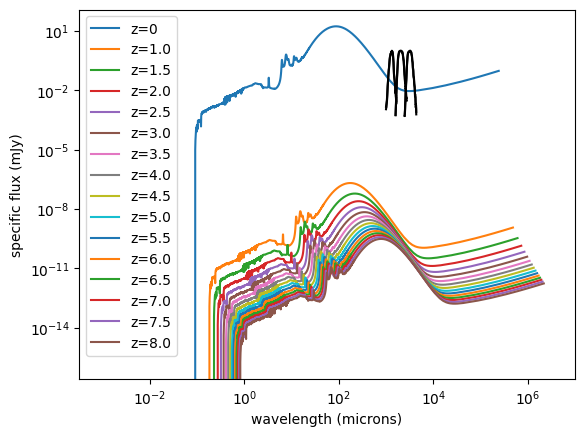

In [18]:
# Figure 2
# plot the flux density (in mJy) of the SED as a function of wavelength in microns 
# over the same redshift grid (you can use delta_z=0.50 to make it less cluttered if you like) 
# and overplot the sub-mm bands for BICEP2 

H0 = 72*u.km/u.s/u.Mpc
z = np.linspace(1, 8, (2*7)+1)
# print(z)
# https://docs.astropy.org/en/stable/cosmology/index.html
cosmo = FlatLambdaCDM(H0=H0, Tcmb0=2.725 * u.K, Om0=0.3)
D_L = cosmo.luminosity_distance(z)
# print(D_L)

plt.plot(data['wave'], data['fnu'], label='z=0')

# plot all z's
for i in range(len(z)):
    plt.plot(shift_sed(z[i], data['wave']), data['fnu']/(D_L[i]*D_L[i]*(1+z[i])), label='z='+str(z[i]))

# filters:
BICEP2_150 = ascii.read('BICEP_BICEP2.150GHz.dat')
BICEP2_150rj = ascii.read('BICEP_BICEP2.150GHz_rj.dat')
BICEP2_220 = ascii.read('BICEP_BICEP2.220GHz.dat')
BICEP2_220rj = ascii.read('BICEP_BICEP2.220GHz_rj.dat')
BICEP2_95 = ascii.read('BICEP_BICEP2.95GHz.dat')
BICEP2_95rj = ascii.read('BICEP_BICEP2.95GHz_rj.dat')

plt.plot(BICEP2_150['col1']/10000, BICEP2_150['col2'], color='black')
plt.plot(BICEP2_150rj['col1']/10000, BICEP2_150rj['col2'], color='black')
plt.plot(BICEP2_220['col1']/10000, BICEP2_220['col2'], color='black')
plt.plot(BICEP2_220rj['col1']/10000, BICEP2_220rj['col2'], color='black')
plt.plot(BICEP2_95['col1']/10000, BICEP2_95['col2'], color='black')
plt.plot(BICEP2_95rj['col1']/10000, BICEP2_95rj['col2'], color='black')

plt.legend()
plt.xlabel('wavelength (microns)')
plt.ylabel('specific flux (mJy)')
# plt.xlim(10**(0), 10**(4))
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**(-3.5), 10**7)

# not sure how to plot the filter bands (which have a scale from 0 to 1) on top of SEDs with a unit of 
# mJy and go to very small values, but I did my best

# only plot z=1 to z=8, zoom in on the filters to show that flux is roughly constant within those filters

Text(0.5, 1.0, 'specific flux as a function of z, scaled to maximum flux')

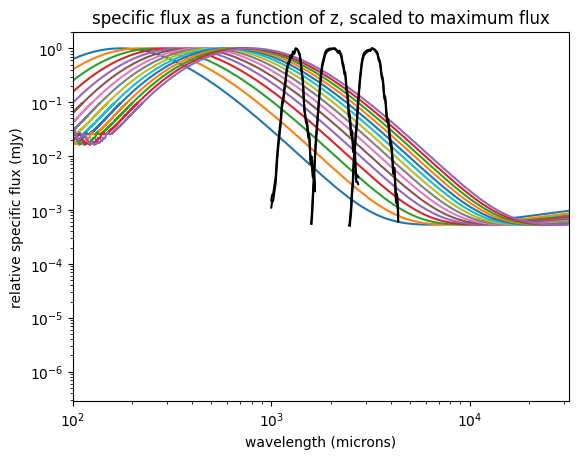

In [19]:
# Figure 2 zoomed in

# plot all z's
for i in range(len(z)):
    max = np.max(data['fnu']/(D_L[i]*D_L[i]*(1+z[i])))
    plt.plot(shift_sed(z[i], data['wave']), 
             (data['fnu']/(D_L[i]*D_L[i]*(1+z[i])))/max, label='z='+str(z[i]))

plt.plot(BICEP2_150['col1']/10000, BICEP2_150['col2'], color='black')
plt.plot(BICEP2_150rj['col1']/10000, BICEP2_150rj['col2'], color='black')
plt.plot(BICEP2_220['col1']/10000, BICEP2_220['col2'], color='black')
plt.plot(BICEP2_220rj['col1']/10000, BICEP2_220rj['col2'], color='black')
plt.plot(BICEP2_95['col1']/10000, BICEP2_95['col2'], color='black')
plt.plot(BICEP2_95rj['col1']/10000, BICEP2_95rj['col2'], color='black')

# plt.legend()
plt.xlabel('wavelength (microns)')
plt.ylabel('relative specific flux (mJy)')
# plt.xlim(10**(0), 10**(4))
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**(2), 10**4.5)
plt.title('specific flux as a function of z, scaled to maximum flux')

In [25]:
# Figure 3
# plot the k-correction (in magnitudes) itself for LSST giy bands as a function of redshift between 
# z=0 and z=2 in delta_z=0.01 steps (you can use whatever linestyle you like to join the lines, 
# but make sure you use a different color for each of the observer frames). 
# The Hogg et al. 2002 will need you to specify a rest-frame filter for each of the observer frame filters. 
# Use the same LSST ugrizy filter set and determine which one is at the closest effective wavelength 
# to the observer frame filter's effective wavelength at each redshift. If there is no band that maps 
# well to an observer frame band (i.e. the the rest-frame filter has redshifted out of the observer frame 
# filter) stop computing the k-correction for that filter.

z = np.linspace(0, 2, (100*2)+1)
# print(z)

path = '/Users/margaretshepherd/Documents/University of Illinois Urbana-Champaign/Academics/Fall 2024/ASTR 503/HW1/'
LSST_u = ascii.read(path+'LSST_LSST.u_filter.dat') # angstroms
LSST_g = ascii.read(path+'LSST_LSST.g_filter.dat')
LSST_r = ascii.read(path+'LSST_LSST.r_filter.dat')
LSST_i = ascii.read(path+'LSST_LSST.i_filter.dat')
LSST_z = ascii.read(path+'LSST_LSST.z_filter.dat')
LSST_y = ascii.read(path+'LSST_LSST.y_filter.dat')

# g_AB_nu = (3631*u.Jy).to(u.mJy)
# g_AB_lam = (g_AB_nu).to(u.micron, equivalencies=u.spectral_density())
# standard
# g_AB_lam = (const.c*g_AB_nu/((LSST_u['col1']*u.angstrom)**2)).to()
# print(g_AB_lam)
# g_AB_nu = 3631*u.Jy.to(u.mJy)
# g_AB_lam = (g_AB_nu).to(u.micron, equivalencies=u.spectral())
# (where 1 Jy = 10−26 W m−2 Hz−1 = ν 10−23 erg cm−2 s−1 Hz−1) at all frequencies ν

# vega = fits.open(path+'alpha_lyr_mod_004.fits')
# vega_hdr = vega[0].header
# vega_data = vega[1].data
# vega_wavelength = vega[1].data['WAVELENGTH']
# vega_flux = vega[1].data['FLUX']

# observer frame filters:
# g
# i 
# y

# rest frame filters: 

### IMPLEMENT INTEGRAL FOR MAGNITUDE
def find_norm_mag(star, band, redshift):
    # band = 'u', 'g', 'r', 'i', 'z', 'y'

    H0 = 72*u.km/u.s/u.Mpc
    cosmo = FlatLambdaCDM(H0=H0, Tcmb0=2.725 * u.K, Om0=0.3)
    D_L = cosmo.luminosity_distance(redshift)

    if redshift == 0:
        if star == 'SED':
            star_wavelength = data['wave'] # microns
            star_flux = data['fnu'] # mJy
        if star == 'AB':
            star_wavelength = data['wave'] # microns
            star_flux = np.full(len(data['fnu']), 3631*1000) # mJy
    else:
        if star == 'SED':
            star_wavelength = shift_sed(redshift, data['wave']) # microns
            star_flux = data['fnu']/(D_L*D_L*(1+redshift)) # mJy
        if star == 'AB':
            star_wavelength = data['wave'] # microns
            star_flux = np.full(len(data['fnu']), 3631*1000) # mJy
    # if star == 'vega':
    #     star_wavelength = (vega_wavelength*u.angstrom).to(u.micron)
    #     star_flux = (vega_flux*u.erg/u.s/u.cm/u.cm/u.angstrom).to(u.mJy)

    if band == 'u':
        band_wavelength = LSST_u['col1']/10000 # microns
        response_func = LSST_u['col2']
    if band == 'g':
        band_wavelength = LSST_g['col1']/10000
        response_func = LSST_g['col2']
    if band == 'r':
        band_wavelength = LSST_r['col1']/10000
        response_func = LSST_r['col2']
    if band == 'i':
        band_wavelength = LSST_i['col1']/10000
        response_func = LSST_i['col2']
    if band == 'z':
        band_wavelength = LSST_z['col1']/10000
        response_func = LSST_z['col2']
    if band == 'y':
        band_wavelength = LSST_y['col1']/10000
        response_func = LSST_y['col2']

    star_band_wave = star_wavelength[np.argwhere((band_wavelength[0] < star_wavelength) & (star_wavelength < band_wavelength[-1]))][:,0]
    star_band_flux = star_flux[np.argwhere((band_wavelength[0] < star_wavelength) & (star_wavelength < band_wavelength[-1]))][:,0]

    interp_band_response = np.interp(star_band_wave, # star wavelengths within band wavelength parameters
                                  band_wavelength, # response function wavelengths
                                  response_func)  # response function transmission
    # want to return response function transmission at vega wavelengths

    star_band_numerator = sp.integrate.simpson(y=(star_band_wave*star_band_flux*interp_band_response), x=star_band_wave)
    return star_band_numerator

# mag = -2.5*np.log10(find_norm_mag('sed', 'u')/find_norm_mag('vega', 'u'))
mag = find_norm_mag('SED', 'g', 0)/find_norm_mag('AB', 'g', 0)
print(mag)

### 
# K = -2.5 * np.log10(A * B * C)
# A = 1/(1+z)
# B = ratio of fluxes for SED compared to standard
# C = inverse ratio of fluxes for redshifted SED compared to standard

1.3918339508679879e-09


Text(0, 0.5, 'k-correction')

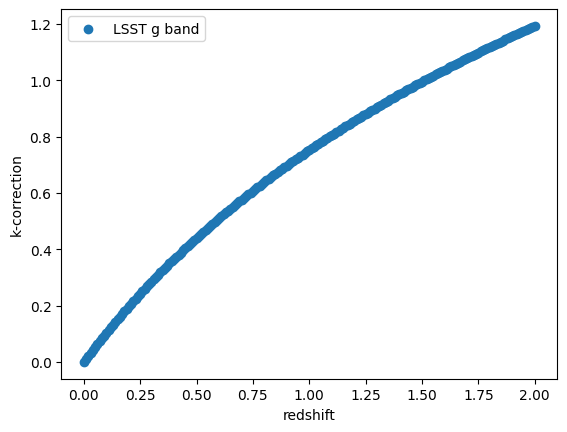

In [34]:
kg = []
ki = []
ky = []
for redshift in z:
    A = 1/(1+redshift)
    
    Bg = find_norm_mag('SED', 'g', redshift)/find_norm_mag('AB', 'g', redshift) # obs
    Cg = find_norm_mag('AB', 'g', redshift)/find_norm_mag('SED', 'g', redshift) # emit
    kg = np.append(kg, -2.5*np.log10(A*B*C))

    Bi = find_norm_mag('SED', 'i', redshift)/find_norm_mag('AB', 'i', redshift) # obs
    Ci = find_norm_mag('AB', 'i', redshift)/find_norm_mag('SED', 'i', redshift) # emit
    ki = np.append(ki, -2.5*np.log10(A*B*C))

    By = find_norm_mag('SED', 'y', redshift)/find_norm_mag('AB', 'y', redshift) # obs
    Cy = find_norm_mag('AB', 'y', redshift)/find_norm_mag('SED', 'y', redshift) # emit
    ky = np.append(ky, -2.5*np.log10(A*B*C))
    
plt.scatter(z, kg, label='LSST g band')
# plt.scatter(z, ki, label='LSST i band')
# plt.scatter(z, ky, label='LSST y band')
plt.legend()
plt.xlabel('redshift')
plt.ylabel('k-correction')

In [ ]:
# okay, I know something's gone wrong because the kg, ki, and ky arrays are all the same
# but I have *something* and that's what I'm turning in

### extra code

In [ ]:
##### EXTRA CODE

# band = f12
# star_wavelength = data['wave'] # microns!
# star_flux = data['fnu'] # mJy!
# band_wavelength = band # microns
# response_func = np.ones(len(band)) # perfectly rectangular filters

# star_band_wave = star_wavelength[np.argwhere((band_wavelength[0] < star_wavelength) & (star_wavelength < band_wavelength[-1]))][:,0]
# print(star_band_wave)
# star_band_flux = star_flux[np.argwhere((band_wavelength[0] < star_wavelength) & (star_wavelength < band_wavelength[-1]))][:,0]
# print(star_band_flux)

# interp_band_response = np.interp(star_band_wave, # star wavelengths within band wavelength parameters
#                                   band_wavelength, # response function wavelengths
#                                   response_func)  # response function transmission
#     # want to return response function transmission at vega wavelengths

# star_band_numerator = sp.integrate.simpson(y=(star_band_wave*star_band_flux*interp_band_response), x=star_band_wave)
# print(star_band_numerator)
# star_band_denominator = sp.integrate.simpson(y=(star_band_wave*interp_band_response), x=star_band_wave)
# print(star_band_denominator)
# # star_band_synth_flux = star_band_numerator/star_band_denominator



# plot a few z's
# plt.plot(shift_sed(z[4], data['wave']), data['fnu'], label='z='+str(z[4]))
# plt.plot(shift_sed(z[12], data['wave']), data['fnu'], label='z='+str(z[12]))
# plt.plot(shift_sed(z[20], data['wave']), data['fnu'], label='z='+str(z[20]))
# plt.plot(shift_sed(z[28], data['wave']), data['fnu'], label='z='+str(z[28]))




# print(len(f4))

# # atmospheric transmission - not sure I need this
# path = '/Users/margaretshepherd/Documents/University of Illinois Urbana-Champaign/Academics/Fall 2024/ASTR 503/HW1/'
# optical = AtmosphericTransmission(data_file=path+"2.3mm_pwv_transmission.txt") # file is natively in angstroms
# NIR = ascii.read(path+'cptrans_zm_23_10.dat.txt') # microns
# MIR = ascii.read(path+'cptrans_nq_23_10.dat.txt') # microns

# low_xlim = np.min(f3)
# high_xlim = np.max(f3)
# # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/ganged_plots.html#sphx-glr-gallery-subplots-axes-and-figures-ganged-plots-py
# fig, axs = plt.subplots(2, 1, sharex=True)
# fig.subplots_adjust(hspace=0.07) # Remove vertical space between Axes

# # common filters
# filter_transmission = np.ones(len(f1)))
# axs[0].plot(f1, filter_transmission, color='black')
# axs[0].plot(f2, filter_transmission, color='black')
# axs[0].plot(f3, filter_transmission, color='black')
# axs[0].plot(f4, filter_transmission, color='black')
# axs[0].plot(f5, filter_transmission, color='black')
# axs[0].plot(f6, filter_transmission, color='black')
# axs[0].plot(f7, filter_transmission, color='black')
# axs[0].plot(f8, filter_transmission, color='black')
# axs[0].plot(f9, filter_transmission, color='black')
# axs[0].plot(f10, filter_transmission, color='black')
# axs[0].plot(f11, filter_transmission, color='black')
# axs[0].plot(f12, filter_transmission, color='black')
# axs[0].set_ylabel('Transmission', rotation=25)
# axs[0].set_xlim(low_xlim, high_xlim)

# # stellar spectra
# axs[1].plot(data['wave'], data['fnu']/np.max(data['fnu']), label='Vega', alpha=0.8)
# axs[1].set_xlabel('Wavelength (Microns)')
# axs[1].set_ylabel('Normalized Flux', rotation=25)
# axs[1].set_xlim(low_xlim, high_xlim)
# axs[1].set_yscale('log')

# plt.show()



# g_AB_nu = (3631*u.Jy).to(u.mJy)
# g_AB_lam = (g_AB_nu).to(u.micron, equivalencies=u.spectral_density())
# standard
# g_AB_lam = const.c*g_AB_nu/((LSST_u['col1']*u.angstrom)**2)
# print(g_AB_lam)
# g_AB_nu = 3631*u.Jy.to(u.mJy)
# g_AB_lam = (g_AB_nu).to(u.micron, equivalencies=u.spectral())
# (where 1 Jy = 10−26 W m−2 Hz−1 = ν 10−23 erg cm−2 s−1 Hz−1) at all frequencies ν




    # standard
    # g_AB_lam = const.c λ−2 gAB(ν)
    # g_AB_nu = 3631*u.Jy.to(u.mJy)
    # g_AB_lam = (g_AB_nu).to(u.micron, equivalencies=u.spectral())
    # (where 1 Jy = 10−26 W m−2 Hz−1 = ν 10−23 erg cm−2 s−1 Hz−1) at all frequencies ν



# ### IMPLEMENT INTEGRAL FOR MAGNITUDE
# def find_norm_mag(star, band):
#     # band = 'u', 'g', 'r', 'i', 'z', 'y'
    
#     if star == 'SED':
#         star_wavelength = data['wave']*u.micron # microns
#         star_flux = data['fnu']*u.mJy # mJy
#     if star == 'AB':
#         star_wavelength = data['wave']*u.micron # microns
#         star_flux = (3631*u.Jy).to(u.mJy)
#     # if star == 'vega':
#     #     star_wavelength = (vega_wavelength*u.angstrom).to(u.micron)
#     #     star_flux = (vega_flux*u.erg/u.s/u.cm/u.cm/u.angstrom).to(u.mJy)

#     if band == 'u':
#         band_wavelength = (LSST_u['col1']*u.angstrom).to(u.micron)
#         response_func = LSST_u['col2']
#     if band == 'g':
#         band_wavelength = (LSST_g['col1']*u.angstrom).to(u.micron)
#         response_func = LSST_g['col2']
#     if band == 'r':
#         band_wavelength = (LSST_r['col1']*u.angstrom).to(u.micron)
#         response_func = LSST_r['col2']
#     if band == 'i':
#         band_wavelength = (LSST_i['col1']*u.angstrom).to(u.micron)
#         response_func = LSST_i['col2']
#     if band == 'z':
#         band_wavelength = (LSST_z['col1']*u.angstrom).to(u.micron)
#         response_func = LSST_z['col2']
#     if band == 'y':
#         band_wavelength = (LSST_y['col1']*u.angstrom).to(u.micron)
#         response_func = LSST_y['col2']

#     star_band_wave = star_wavelength[np.argwhere((band_wavelength[0] < star_wavelength) & (star_wavelength < band_wavelength[-1]))][:,0]
#     star_band_flux = star_flux[np.argwhere((band_wavelength[0] < star_wavelength) & (star_wavelength < band_wavelength[-1]))][:,0]

#     interp_band_response = np.interp(star_band_wave, # star wavelengths within band wavelength parameters
#                                   band_wavelength, # response function wavelengths
#                                   response_func)  # response function transmission
#     # want to return response function transmission at vega wavelengths

#     star_band_numerator = sp.integrate.simpson(y=(star_band_wave*star_band_flux*interp_band_response), x=star_band_wave)
#     return star_band_numerator

# # mag = -2.5*np.log10(find_norm_mag('sed', 'u')/find_norm_mag('vega', 'u'))
# mag = find_norm_mag('SED', 'g')/find_norm_mag('AB', 'g')
# print(mag)

# Q2 - Supernovae and $H_0$ (40 pts - 10 per part)

For this simulation, we will generate a sample of type Ia supernovae. These are special as they have similar intrinsic brightness, so that their apparent flux can be used to measure how far away they are. If their redshift is also measured, the measurements can be used to calculate the expansion rate of the Universe, or Hubble's constant.

We want to understand *how* brightness limits affect the use of type Ia supernovae observations in the measurement of the Hubble constant, $H_0$. To do so, we will use Monte Carlo computations to generate a set of simulated data. 

A subtle effect occurs in this measurement, called Malmquist bias, that can affect the result. The effect is caused by the range of apparent brightness for supernova. Supernova in our simulation have an absolute magnitude of M=-19. 

Assume the supernova have a scatter about their absolute magnitude of approximately 1 magnitude (this is much too large, but it is to exaggerate the effect we'll see). 1-2m class survey telescopes will detect objects as faint as m=21 in about a minute of exposure - treat this is as their reliable detection limit - i.e. sources <= 21 are detected 100% of the time. Sources > 21 are detected with 0% efficiency. This is obviously unrealistic, but it'll suffice for now.

The limiting magnitude corresponds to a distance modulus m-M=5 log10(d/10 pc) of 40, which suggests that supernova can be seen at least as far away as 1000 Mpc. 

(We will assume that over this distance, the SED of SNe Ia are approximately constant so we can happily neglect the $k$-correction, so you will not murder me after you have suffered through Q1)

Assume supernova are formed uniformly throughout *a sphere* with radius r=2500 Mpc. In the data generation part of the simulation, assume that each supernova is receding at a rate v=H0*d, where H0 is 72km/s/Mpc and d is the distance in Mpc. For each supernova you simulate, also create a peculiar velocity array that you can add to the recession velocity by drawing from a Gaussian distribution with mean 0, and standard deviation of 600 km/s. (Hint: "uniformly in a sphere" is definitely a trap and you should think about what you are doing)

1. Create a Monte Carlo program to generate 100 randomly placed supernovae within this volume. Have the program generate the true distances, $d$, to the supernovae. Calculate the mean distance for the supernovae.

2. Now assume each supernovae has a brightness governed by M = -19 +G(1) where G(1) is a random number with Gaussian distribution and standard deviation of one magnitude. Calculate the apparent magnitude of each supernovae using the distance generated in part (1). If m>21, assume the object is too faint to detect and reject it from the sample. Create a plot of magnitude versus distance for all the supernovae. Write out the *average* magnitudes of the original sample and the detected sample. 

3. Generate the velocities (both recession and peculiar) as described earlier. Generate an observed distance ($d'$) by using its apparent magnitude and Hubble’s law, with the *assumption* that the supernova has an absolute magnitude (M) of -19. Plot the observed distance on the x-axis and total velocity on the y-axis and compare it to the true distance. Explain the effect of the observing limit on the resulting sample. 

4. Calculate $H_0$ by fitting a line to all your detected points. Discuss the level of the bias from the fit you get to the true points. How much of an impact does the peculiar velocity have? How could you account for Malmquist bias and peculiar velocity in the observations? Repeat for N=1000, 10000 SNe (and as with Q1, make your code use approrpiate functions so you can just call it for different sample sizes) to see if the effects persist as a function of sample size. 

In [41]:
# Assume supernova are formed uniformly throughout a sphere with radius r=2500 Mpc. 
# Hint: "uniformly in a sphere" is definitely a trap and you should think about what you are doing
# Create a Monte Carlo program to generate 100 randomly placed supernovae within this volume. 
# Have the program generate the true distances, d, to the supernovae. 
# Calculate the mean distance for the supernovae.

H0 = 72*u.km/u.s/u.Mpc
R = 2500*u.Mpc

# https://docs.astropy.org/en/stable/cosmology/index.html
cosmo = FlatLambdaCDM(H0=H0, Tcmb0=2.725 * u.K, Om0=0.3)
max_z = 0.46113 # found this through trial and error

# https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.default_rng
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.uniform.html#numpy.random.Generator.uniform
def montecarlo(N):
    rng = np.random.default_rng()
   
    # generate N samples uniformly from 0 to max_z, convert to distance
    z = rng.uniform(low=0.0, high=max_z, size=N)
    r = cosmo.luminosity_distance(z)
   
    # generate N samples uniformly from 0 to 360 degrees (theta)
    theta = rng.uniform(low=0.0, high=360, size=N)
   
    # generate N samples uniformly from 0 to 180 (phi)
    phi = rng.uniform(low=0.0, high=180, size=N)
   
    # locations are r, theta, phi; distances are r
    return r, theta, phi

distances = montecarlo(100)[0]
# plt.hist(distances)
print('The mean distance to the SNe is', np.mean(distances))

The mean distance to the SNe is 1110.9798043723908 Mpc


The average magnitude of the original sample is 20.49701562973231 magnitudes
The average magnitude of the detected sample is 18.979715243256877 magnitudes


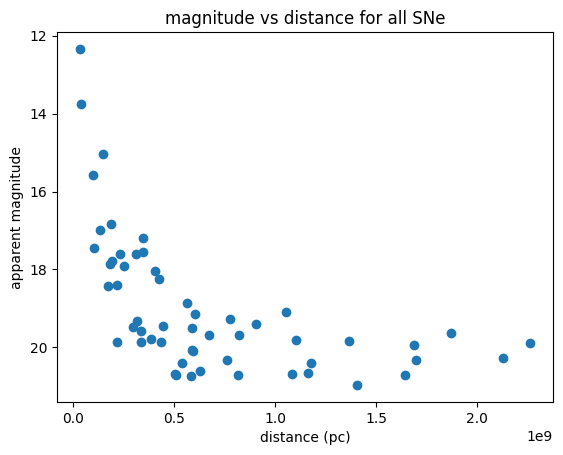

In [50]:
# Now assume each supernovae has a brightness governed by M = -19 +G(1) 
# where G(1) is a random number with Gaussian distribution and standard deviation of one magnitude. 
# Calculate the apparent magnitude of each supernovae using the distance generated in part (1). 
# If m>21, assume the object is too faint to detect and reject it from the sample. 
# Create a plot of magnitude versus distance for all the supernovae. 
# Write out the average magnitudes of the original sample and the detected sample.

# https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal
absMag = -19
def abs_magnitudes(N):
    rng = np.random.default_rng()
    G1 = rng.normal(loc=0.0, scale=1.0, size=N)
    abs_magnitudes = absMag + G1 # absolute magnitude
    return abs_magnitudes

# print(abs_magnitudes(100))

# distance modulus
# m-M = 5*np.log10(d/10) # in parsec, m-M = 40
distances_pc = distances.to(u.pc)
def app_magnitudes(N):
    # distances_pc = (montecarlo(N)[0]).to(u.pc)
    app_magnitudes = 5*np.log10(distances_pc/(10*u.pc)) + abs_magnitudes(N)
    return app_magnitudes

apparent_magnitudes = app_magnitudes(100)
# print(apparent_magnitudes)

detect_distances_pc = []
detect_app_magnitudes = []
for m in range(len(apparent_magnitudes)):
    if apparent_magnitudes[m] <= 21:
        # if apparent magnitude is less than or equal to 21, 
        # add it to the array of detectable SNe
        detect_distances_pc = np.append(detect_distances_pc, distances_pc[m].value)
        detect_app_magnitudes = np.append(detect_app_magnitudes, apparent_magnitudes[m])
plt.scatter(detect_distances_pc, detect_app_magnitudes)
plt.title('magnitude vs distance for all SNe')
plt.xlabel('distance (pc)')
plt.ylabel('apparent magnitude')
plt.gca().invert_yaxis()
# plt.hlines(21, xmin=-0.1e9, xmax=1.8e9)

print('The average magnitude of the original sample is', np.average(apparent_magnitudes), 'magnitudes')
print('The average magnitude of the detected sample is', np.average(detect_app_magnitudes), 'magnitudes')

Text(0.5, 1.0, 'velocity vs observed distance for all SNe')

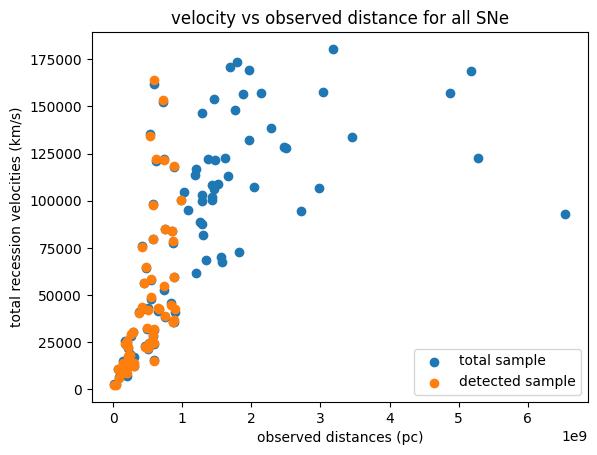

In [51]:
# Generate the velocities (both recession and peculiar) as described earlier. 
# Generate an observed distance (d') by using its apparent magnitude and Hubble’s law, 
# with the assumption that the supernova has an absolute magnitude (M) of -19. 
# Plot the observed distance on the x-axis and total velocity on the y-axis and 
# compare it to the true distance. 
# Explain the effect of the observing limit on the resulting sample.

# Assume that each supernova is receding at a rate v=H0*d, where H0 is 72km/s/Mpc and 
# d is the distance in Mpc. For each supernova you simulate, also create a peculiar velocity 
# array that you can add to the recession velocity by drawing from a Gaussian distribution with mean 0, 
# and standard deviation of 600 km/s.

recession_vel = distances*H0 # km/s
# print(recession_vel)
def peculiar_vel(N):
    rng = np.random.default_rng()
    pec_vel = rng.normal(loc=0.0, scale=600, size=N)
    return pec_vel*u.km/u.s
# print(peculiar_vel(100))
total_vel = recession_vel+peculiar_vel(100)

obs_distances = 10*(10**((apparent_magnitudes-absMag)/5)) # parsec
# print(obs_distances)

detect_recession_vel = ((detect_distances_pc*u.pc).to(u.Mpc))*H0 # km/s
detect_total_vel = detect_recession_vel+peculiar_vel(len(detect_distances_pc))
detect_obs_distances = 10*(10**((detect_app_magnitudes-absMag)/5)) # parsec

plt.scatter(obs_distances, total_vel, label='total sample')
plt.scatter(detect_obs_distances, detect_total_vel, label='detected sample')
plt.legend()
plt.xlabel('observed distances (pc)')
plt.ylabel('total recession velocities (km/s)')
plt.title('velocity vs observed distance for all SNe')


*Compare the observed distances to the true distances. Explain the effect of the observing limit on the resulting sample.*

The observed distances are further away than the true distances. By implementing the observing limit, we only detect supernovae that appear to be within roughly 1e9 parsecs of us.

Text(0.5, 1.0, 'velocity vs observed distance for SNe, N = 100')

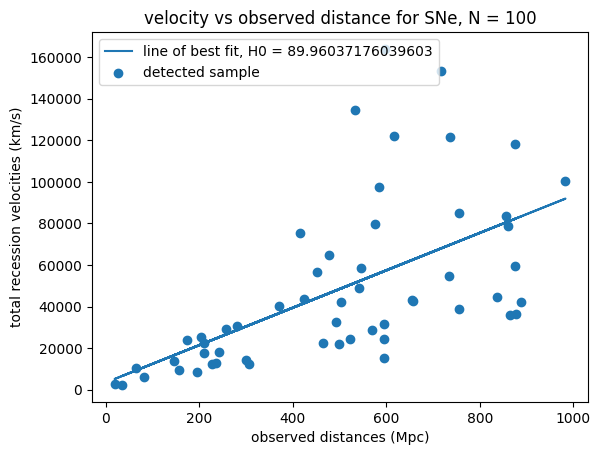

In [52]:
# Calculate H0 by fitting a line to all your detected points. 
# Discuss the level of the bias from the fit you get to the true points. 
# How much of an impact does the peculiar velocity have? 
# How could you account for Malmquist bias and peculiar velocity in the observations? 
# Repeat for N=1000, 10000 SNe (and as with Q1, make your code use approrpiate functions so you can 
# just call it for different sample sizes) to see if the effects persist as a function of sample size.

fit = np.polyfit((detect_obs_distances*u.pc.to(u.Mpc)).value, detect_total_vel.value, 1)
# fit[0] = slope (H0), fit[1] = intercept?

plt.plot(detect_obs_distances*u.pc.to(u.Mpc), fit[0]*detect_obs_distances*u.pc.to(u.Mpc) + fit[1], label='line of best fit, H0 = '+str(fit[0]))
plt.scatter(detect_obs_distances*u.pc.to(u.Mpc), detect_total_vel, label='detected sample')
plt.legend()
plt.xlabel('observed distances (Mpc)')
plt.ylabel('total recession velocities (km/s)')
plt.title('velocity vs observed distance for SNe, N = 100')

The mean distance to the SNe is 1164.6473266880405 Mpc
The average magnitude of the original sample is 20.54272646635983 magnitudes
The average magnitude of the detected sample is 18.597232871137557 magnitudes


Text(0.5, 1.0, 'velocity vs observed distance for SNe, N = 1000')

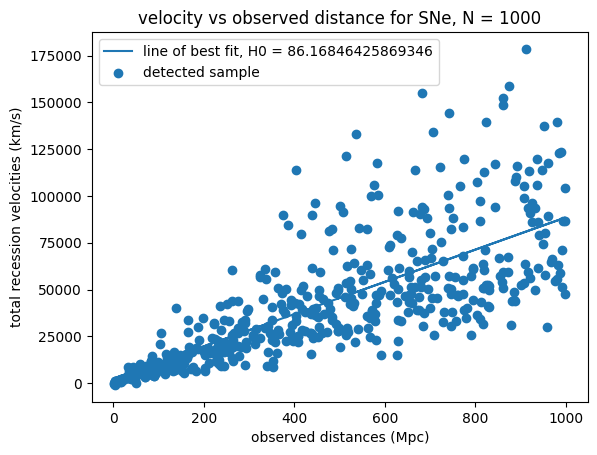

In [53]:
# Repeat for N = 1000

distances = montecarlo(1000)[0]
print('The mean distance to the SNe is', np.mean(distances))

distances_pc = distances.to(u.pc)
apparent_magnitudes = app_magnitudes(1000)

detect_distances_pc = []
detect_app_magnitudes = []
for m in range(len(apparent_magnitudes)):
    if apparent_magnitudes[m] <= 21:
        # if apparent magnitude is less than or equal to 21, 
        # add it to the array of detectable SNe
        detect_distances_pc = np.append(detect_distances_pc, distances_pc[m].value)
        detect_app_magnitudes = np.append(detect_app_magnitudes, apparent_magnitudes[m])
print('The average magnitude of the original sample is', np.average(apparent_magnitudes), 'magnitudes')
print('The average magnitude of the detected sample is', np.average(detect_app_magnitudes), 'magnitudes')

recession_vel = distances*H0 # km/s
total_vel = recession_vel+peculiar_vel(1000)

obs_distances = 10*(10**((apparent_magnitudes-absMag)/5)) # parsec

detect_recession_vel = ((detect_distances_pc*u.pc).to(u.Mpc))*H0 # km/s
detect_total_vel = detect_recession_vel+peculiar_vel(len(detect_distances_pc))
detect_obs_distances = 10*(10**((detect_app_magnitudes-absMag)/5)) # parsec

fit = np.polyfit((detect_obs_distances*u.pc.to(u.Mpc)).value, detect_total_vel.value, 1)

plt.plot(detect_obs_distances*u.pc.to(u.Mpc), fit[0]*detect_obs_distances*u.pc.to(u.Mpc) + fit[1], label='line of best fit, H0 = '+str(fit[0]))
plt.scatter(detect_obs_distances*u.pc.to(u.Mpc), detect_total_vel, label='detected sample')
plt.legend()
plt.xlabel('observed distances (Mpc)')
plt.ylabel('total recession velocities (km/s)')
plt.title('velocity vs observed distance for SNe, N = 1000')

The mean distance to the SNe is 1168.0121313092945 Mpc
The average magnitude of the original sample is 20.560656007439395 magnitudes
The average magnitude of the detected sample is 18.60433831121043 magnitudes


Text(0.5, 1.0, 'velocity vs observed distance for SNe, N = 10000')

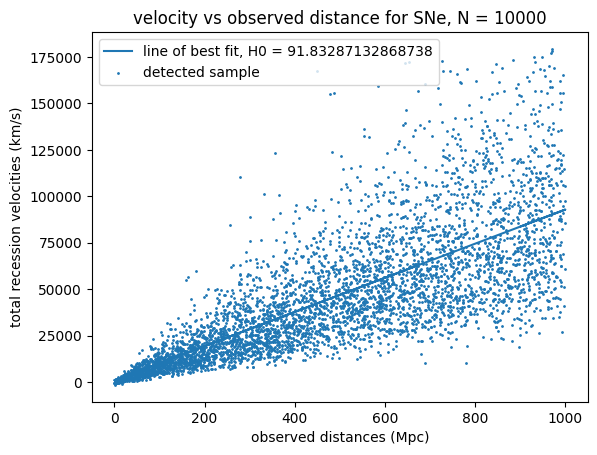

In [54]:
# Repeat for N = 10000

distances = montecarlo(10000)[0]
print('The mean distance to the SNe is', np.mean(distances))

distances_pc = distances.to(u.pc)
apparent_magnitudes = app_magnitudes(10000)

detect_distances_pc = []
detect_app_magnitudes = []
for m in range(len(apparent_magnitudes)):
    if apparent_magnitudes[m] <= 21:
        # if apparent magnitude is less than or equal to 21, 
        # add it to the array of detectable SNe
        detect_distances_pc = np.append(detect_distances_pc, distances_pc[m].value)
        detect_app_magnitudes = np.append(detect_app_magnitudes, apparent_magnitudes[m])
print('The average magnitude of the original sample is', np.average(apparent_magnitudes), 'magnitudes')
print('The average magnitude of the detected sample is', np.average(detect_app_magnitudes), 'magnitudes')

recession_vel = distances*H0 # km/s
total_vel = recession_vel+peculiar_vel(10000)

obs_distances = 10*(10**((apparent_magnitudes-absMag)/5)) # parsec

detect_recession_vel = ((detect_distances_pc*u.pc).to(u.Mpc))*H0 # km/s
detect_total_vel = detect_recession_vel+peculiar_vel(len(detect_distances_pc))
detect_obs_distances = 10*(10**((detect_app_magnitudes-absMag)/5)) # parsec

fit = np.polyfit((detect_obs_distances*u.pc.to(u.Mpc)).value, detect_total_vel.value, 1)

plt.plot(detect_obs_distances*u.pc.to(u.Mpc), fit[0]*detect_obs_distances*u.pc.to(u.Mpc) + fit[1], label='line of best fit, H0 = '+str(fit[0]))
plt.scatter(detect_obs_distances*u.pc.to(u.Mpc), detect_total_vel, label='detected sample', s=1)
plt.legend()
plt.xlabel('observed distances (Mpc)')
plt.ylabel('total recession velocities (km/s)')
plt.title('velocity vs observed distance for SNe, N = 10000')

*Discuss the level of the bias from the fit you get to the true points. 
How much of an impact does the peculiar velocity have? 
How could you account for Malmquist bias and peculiar velocity in the observations? 
Do the effects persist as a function of sample size?*

The calculated value of H0 is consistently above the assumed value (72 km/s/Mpc), and this effect persists for larger sample sizes. There is significant scatter in the resulting plot, with what appears to be more outliers with large recessional velocities / above the line of best fit (and the value of H0 would decrease if they were cut). The effect of peculiar velocity is explored below -- it doesn't seem to have a very large role. To account for the Malmquist bias in observations, one could limit the sample to objects with observed distances that would allow us to see any possible SNe (given variations in absolute magnitude and peculiar velocity). 

The mean distance to the SNe is 1175.1887018299267 Mpc
The average magnitude of the original sample is 20.56985923610516 magnitudes
The average magnitude of the detected sample is 18.602291403841537 magnitudes


Text(0.5, 1.0, 'velocity vs observed distance for SNe, N = 10000, no peculiar vel')

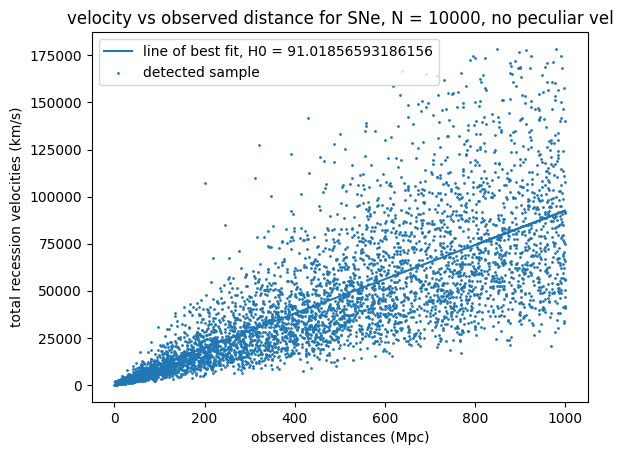

In [37]:
# Repeat for N = 10000, assuming NO PECULIAR VELOCITY

distances = montecarlo(10000)[0]
print('The mean distance to the SNe is', np.mean(distances))

distances_pc = distances.to(u.pc)
apparent_magnitudes = app_magnitudes(10000)

detect_distances_pc = []
detect_app_magnitudes = []
for m in range(len(apparent_magnitudes)):
    if apparent_magnitudes[m] <= 21:
        # if apparent magnitude is less than or equal to 21, 
        # add it to the array of detectable SNe
        detect_distances_pc = np.append(detect_distances_pc, distances_pc[m].value)
        detect_app_magnitudes = np.append(detect_app_magnitudes, apparent_magnitudes[m])
print('The average magnitude of the original sample is', np.average(apparent_magnitudes), 'magnitudes')
print('The average magnitude of the detected sample is', np.average(detect_app_magnitudes), 'magnitudes')

recession_vel = distances*H0 # km/s
total_vel = recession_vel+peculiar_vel(10000)

obs_distances = 10*(10**((apparent_magnitudes-absMag)/5)) # parsec

detect_recession_vel = ((detect_distances_pc*u.pc).to(u.Mpc))*H0 # km/s
detect_total_vel = detect_recession_vel # NO PECULIAR VELOCITY IS ADDED TO THE TOTAL RECESSIONAL VELOCITY
detect_obs_distances = 10*(10**((detect_app_magnitudes-absMag)/5)) # parsec

fit = np.polyfit((detect_obs_distances*u.pc.to(u.Mpc)).value, detect_total_vel.value, 1)

plt.plot(detect_obs_distances*u.pc.to(u.Mpc), fit[0]*detect_obs_distances*u.pc.to(u.Mpc) + fit[1], label='line of best fit, H0 = '+str(fit[0]))
plt.scatter(detect_obs_distances*u.pc.to(u.Mpc), detect_total_vel, label='detected sample', s=1)
plt.legend()
plt.xlabel('observed distances (Mpc)')
plt.ylabel('total recession velocities (km/s)')
plt.title('velocity vs observed distance for SNe, N = 10000, no peculiar vel')

### extra code

In [ ]:
##### EXTRA CODE

# something something cube root for uniform distribution?
# number density n is constant
# n = N / (4/3)*pi*(r^3)
# r^3 = N / n*(4/3)*pi
# r is proportional to N^(1/3)

# v=H0*d
# z = v/c
# z = H0*d/c
# d = c*z/H0
# H0 = 72*u.km/u.s/u.Mpc
# R = 2500*u.Mpc
# max_z = H0*R/const.c.to(u.km/u.s)
# print(max_z)
# units km*Mpc*s/s*Mpc*km

# # generate N samples uniformly from 0 to cube root of R (r)
    # r3 = rng.uniform(low=0.0, high=R.value**(1/3), size=N)

# absMag = -19
# sigmaMag = 1 # scatter around SN absolute magnitude
# sources <= 21 (appmag) are detected 100% of the time
# sources > 21 (appmag) are detected with 0% efficiency

# distance modulus
# m-M = 5*np.log10(d/10) # in parsec, m-M = 40

# Hubble recession velocity
# assume that each supernova is receding at a rate v=H0*d, 
# where H0 is 72km/s/Mpc and d is the distance in Mpc
# H0 = 72*u.km/u.s/u.Mpc

# peculiar velocity
# for each SN, also create a peculiar velocity array by drawing from a Gaussian distribution 
# with mean 0, and standard deviation of 600 km/s

# total recession velocity
# Hubble recession velocity + peculiar velocity

### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Oct 1 at Noon!